In [1]:
import pandas as pd
import numpy as np
import json
import os
import random
from tqdm import tqdm

file_list = [file for file in os.listdir(os.path.join(
    os.getcwd(), 'dataset')) if file.endswith('.json')]
# file_list = random.choices(file_list, k=10)
print(f"file list length: {len(file_list)}")

# file iterator


def file_iterator(file_list, show_progress=False):
    if show_progress:
        for i in tqdm(range(len(file_list))):
            with open(os.path.join(os.getcwd(), 'dataset', file_list[i]), 'r') as f:
                data = json.load(f)
            yield data
    else:
        for i in range(len(file_list)):
            with open(os.path.join(os.getcwd(), 'dataset', file_list[i]), 'r') as f:
                data = json.load(f)
            yield data

file list length: 3236


### 위기 단계의 정도를 확인


In [2]:
results = {}
for file in file_iterator(file_list, show_progress=True):
    samples = file['list']  # json 라이브러리 이용
    for sample in samples:
        if sample['위기단계'] in results:
            results[sample['위기단계']].append(sample['문항합계'])
        else:
            results[sample['위기단계']] = [sample['문항합계']]

results.pop('')
results.pop("해당없음")
for key in results.keys():
    min_val = min(results[key])
    max_val = max(results[key])
    average = round(np.mean(results[key]), 2)
    std = round(np.std(results[key]), 2)
    print(f"{key}: min: {min_val}, max: {max_val}, average: {average}, std: {std}")

100%|██████████| 3236/3236 [00:01<00:00, 2640.71it/s]

정상군: min: 0, max: 14, average: 1.35, std: 1.82
관찰필요: min: 0, max: 18, average: 6.63, std: 2.23
상담필요: min: 5, max: 23, average: 9.97, std: 3.83
위기아동: min: 6, max: 38, average: 13.2, std: 5.65
학대의심: min: 7, max: 29, average: 12.54, std: 4.54


In [3]:
temp_df_list = []
for file in file_iterator(file_list, show_progress=True):
    info = file['info']
    for i in range(len(file['list'])):
        for j in range(len(file['list'][i]['list'])):
            item = file['list'][i]['list'][j]
            dialog = ""
            if 'audio' not in item:
                continue
            for k in range(len(item['audio'])):
                dialog += f"{item['audio'][k]['type']}: {item['audio'][k]['text']}\n"
            temp_df_list.append({
                '성별': info['성별'],
                '나이': info['나이'],
                '학년': info['학년'],
                '종합위기단계': info['위기단계'],
                '항목': item['항목'],
                '위기단계': file['list'][i]['위기단계'],
                '위기점수': item['점수'],
                '임상가코멘트': item['임상가코멘트']['val'].replace(',', '') if 'val' in item['임상가코멘트'] else None,
                '대화': dialog.replace(',', '')
            })

df = pd.DataFrame(temp_df_list)
df.loc[df['위기점수'] == 0, '위기단계'] = '해당없음'

df = df.astype({
    '성별': 'category',
    '나이': 'int',
    '학년': 'category',
    '종합위기단계': 'category',
    '항목': 'category',
    '위기단계': 'category',
    '위기점수': 'int',
    '임상가코멘트': 'str',
    '대화': 'str'
})
df.to_csv('origin_data.csv', index=False)
df.tail(10)

100%|██████████| 3236/3236 [00:00<00:00, 3872.87it/s]


,성별,나이,학년,종합위기단계,항목,위기단계,위기점수,임상가코멘트,대화
70234,여,12,고학년,학대의심,미래/진로,해당없음,0,① 미래에 대한 희망적 요인(꿈/진로)이 긍정적인 자원으로 기능할 것으로 보입니다 ...,Q: 커서 어떤 사람이 되고 싶어? 꿈이 있어?\nA: 저는 카페주인 하고 싶어요....
70235,여,12,고학년,학대의심,방임,해당없음,0,① 적절한 돌봄을 받고 있는 것으로 여겨집니다. [0점],Q: 주로 나를 돌봐주는 어른은 누구셔?\nA: 엄마요.\nQ: 배가 고픈데 먹을 ...
70236,여,12,고학년,학대의심,정서학대,학대의심,8,③ 정서적 학대 의심으로 극심한 어려움이나 정신증적 양상으로 이어질 수 있습니다. ...,Q: 주변 어른들 때문에 기분이 안 좋아진 적이 있어?\nA: 영어학원 선생님이요....
70237,여,12,고학년,학대의심,신체학대,해당없음,0,① 신체적 학대의 징후가 유추되지 않습니다. [0점],Q: 주위 어른들 중 친구를 때린 사람이 있었어?\nA: 때린 사람은 없어요.\nQ...
70238,여,12,고학년,학대의심,성학대,해당없음,0,① 성적 학대의 징후가 유추되지 않습니다. [0점],Q: 조금 예민한 질문인데 친구가 원하지 않는데도 누군가 친구 몸을 만지거나 보여달...
70239,여,12,고학년,학대의심,가정폭력,해당없음,0,① 유의한 가정폭력 징후가 유추되지 않습니다. [0점],Q: 집에서 어른들끼리 소리 지르면서 싸우는 걸 듣거나 본 적이 있어?\nA: 아니...
70240,여,12,고학년,학대의심,학교폭력,해당없음,0,① 학교 폭력의 징후가 유추되지 않습니다. [0점],Q: 친구나 또래가 나를 자주 놀리거나 괴롭힌다고 느낀 적이 있어?\nA: 친구들이...
70241,여,12,고학년,학대의심,자해/자살,위기아동,6,③ 자살사고가 있으나 행동으로 이어지지 않는 것으로 보입니다. 지속적 추적 관찰이 ...,Q: 어떨 때 마음이 복잡하거나 힘들어?\nA: 영어 선생님이 애들 앞에서 수치스럽...
70242,여,12,고학년,학대의심,트라우마,위기아동,8,⑤ 외상 경험이 꿈으로 이어지고 있어 적절한 심리적 개입이 요구됩니다. [8점],Q: 잠잘 때 주로 어떤 꿈을 꿔?\nA: 모두가 손가락질하는 꿈이요.\nQ: 그런...
70243,여,12,고학년,학대의심,가출경험 및 가출중 정황,해당없음,0,① 유의한 가출경험 징후가 유추되지 않습니다. [0점],Q: 어른들 허락이나 말도 없이 집에 오랫동안 나와 있었던 적이 있었어?\nA: 아...


In [4]:
# Read the original CSV file
df = pd.read_csv('origin_data.csv')

# Filter the DataFrame based on '항목' values
df = df[df['항목'].isin([
    '정서학대', '신체학대', '방임', '성학대', '가정폭력',
    '학교폭력', '자해/자살', '트라우마', '가출'
])].loc[:, ['항목', '위기점수', '대화']]

# Set '항목' to '해당없음' where '위기점수' is 0
df.loc[df['위기점수'] == 0, '항목'] = '해당없음'

# 항목이 '해당없음' 인 값들 중 무작위로 선정된 1000개만 남기고 나머지는 삭제
# new_df = df[df['항목'] != '해당없음']
# df = df.groupby('항목').apply(lambda x: x.sample(1000)).reset_index(drop=True)
# # df.to_csv('result_filtered.csv', index=False)

# Sample data: Keep all non-'해당없음' rows and 1000 '해당없음' rows
df = pd.concat([
    df[df['항목'] != '해당없음'],
    df.loc[df['항목'] == '해당없음'].sample(1000)
]).sample(frac=1).reset_index(drop=True)

# Drop the '위기점수' column
simple_field_df = df.drop(columns=['위기점수'])

# **Replace newline characters in '대화' column**
simple_field_df['대화'] = simple_field_df['대화'].str.replace(
    '\r\n|\r|\n', ' ', regex=True)

# Save the DataFrame to 'simple_field.csv'
simple_field_df.to_csv('simple_field.csv', index=False, encoding='utf-8')

# Display value counts for '항목'
print(simple_field_df['항목'].value_counts())

해당없음     1000
트라우마      989
정서학대      957
신체학대      654
방임        513
자해/자살     438
가정폭력      349
학교폭력      291
성학대       289
Name: 항목, dtype: int64


Total value count:  5480


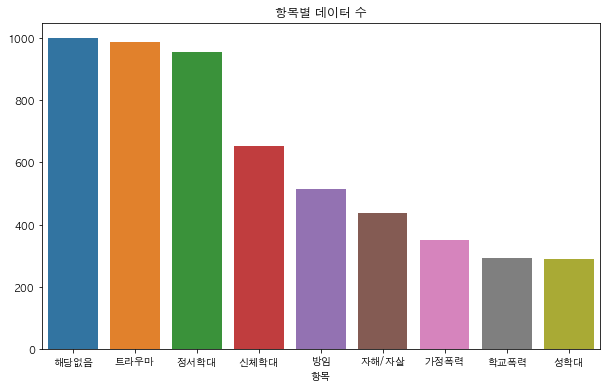

In [14]:
import pandas as pd
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("simple_field.csv")
counts = df.value_counts("항목")
print("Total value count: ", counts.sum())

# 그래프 한글
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


# counts 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title("항목별 데이터 수")
plt.show()

In [5]:
suffixes = np.select([
    df['위기점수'].between(1, 3),
    df['위기점수'].between(4, 6),
    df['위기점수'].between(7, 10)
], ['_주의', '_우려', '_위험'], default='')

df['항목'] = df['항목'] + suffixes
df = df.drop(columns=['위기점수'])
df['대화'] = df['대화'].str.replace(
    '\r\n|\r|\n', ' ', regex=True)

# 항목이 '해당없음' 인 값들 중 무작위로 500개만 선정
df = pd.concat([
    df[df['항목'] != '해당없음'],
    df.loc[df['항목'] == '해당없음'].sample(500)
]).sample(frac=1).reset_index(drop=True)


df.to_csv('field.csv', index=False, encoding='utf-8')
df.groupby('항목').count().T

항목,가정폭력_우려,가정폭력_위험,가정폭력_주의,방임_우려,방임_위험,방임_주의,성학대_우려,성학대_위험,신체학대_우려,신체학대_위험,...,정서학대_우려,정서학대_위험,정서학대_주의,트라우마_우려,트라우마_위험,트라우마_주의,학교폭력_우려,학교폭력_위험,학교폭력_주의,해당없음
대화,110,227,12,290,215,8,76,213,124,513,...,727,206,24,455,442,92,117,168,6,500
